# Computer Vision Coursework Submission (INM460)

**Student name, ID and cohort:** MORTEZA LAYEGH MIRHOSSEINI (220003166) - PG


### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Define Local Path


In [ ]:
import os

# TODO: Fill in the Google Drive path where you uploaded the CW_folder_PG
# Example: GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/Computer Vision/CW_folder_PG'

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'CW_Folder_PG' 
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Video', 'Code', 'CW_Dataset', 'Models', 'test_functions.ipynb']


### Load packages 

In [ ]:
import matplotlib.pyplot as plt
from joblib import dump, load
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import copy
import os
%matplotlib inline
import random
import cv2
import pickle
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from skimage.feature import hog
from skimage import exposure
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from skimage.transform import AffineTransform, warp
from skimage.feature import hog
from PIL import Image
from sklearn import svm
from skimage import io

random.seed(1234)
import shutil
from skimage import io, color, img_as_ubyte
from matplotlib import patches
!pip install facenet-pytorch
from facenet_pytorch import MTCNN


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Load models

In the next cell you should load all your trained models for easier testing of your functions. Avoid to load them within `MaskDetection` and `MaskDetectionVideo` to avoid having to reload them each time.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16) 
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()


In [ ]:
# hog-svm = load(os.path.join(GOOGLE_DRIVE_PATH, 'Models','hog-svm.joblib'))

# model paths 
model_ft_path = os.path.join(GOOGLE_DRIVE_PATH, 'Models','CNN_transfer.pth')
model_CNN_BASIC_path = os.path.join(GOOGLE_DRIVE_PATH, 'Models','CNN_BASIC.pth')
model_SVM_path = os.path.join(GOOGLE_DRIVE_PATH, 'Models','gridsearch_svm.pickle')
model_MLP_path = os.path.join(GOOGLE_DRIVE_PATH, 'Models','MLP.pickle')

 
# Load CNN-transfer 
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 3.
model_ft.fc = nn.Linear(num_ftrs, 3)
model_ft.load_state_dict(torch.load(model_ft_path))
model_ft.eval() 


# Load CNN-basic
model_CNN_BASIC = Net()
model_CNN_BASIC.load_state_dict(torch.load(model_CNN_BASIC_path))
model_CNN_BASIC.eval()


#load SVM and MLP
with open(model_SVM_path, 'rb') as f:
  model_SVM = pickle.load(f)

with open(model_MLP_path, 'rb') as f:
  model_MLP = pickle.load(f)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


# Test MaskDetection

This section should allow a quick test of the `MaskDetection` function. First, add cells with the code needed to load the necessary subroutines to make `MaskDetection` work.

# Unzip and creating directory format of the dataset
In this section, we unzip the provided dataset, create a directory called 'test'. Within this folder subfolder, we have three  subfolders for each image class labeled as 0, 1, and 2

In [ ]:
import os
# Identify path to zipped dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset/CV2023_CW_Dataset.zip')

# Copy it to Colab
!cp '{zip_path}' .

# Unzip it (removing useless files stored in the zip)
!yes|unzip -q CV2023_CW_Dataset.zip

# Delete zipped version from Colab (not from Drive)
!rm CV2023_CW_Dataset.zip
#############################################################


In [ ]:
import os
import shutil
# Define path to test folder inside the dataset
test_path = "./test/"

# Define path to the labels folder inside the test folder
test_labels_path = os.path.join(test_path, "labels")

# Define path to the images folder inside the test folder
test_images_path = os.path.join(test_path, "images")

# Create the folders for each class (0, 1, 2) inside the test folder
for class_id in range(3):
    class_path = os.path.join(test_path, str(class_id))
    os.makedirs(class_path, exist_ok=True)

# Loop through each image in the test images folder and move them to the appropriate class folder
for image_name in os.listdir(test_images_path):
    image_path = os.path.join(test_images_path, image_name)
    label_path = os.path.join(test_labels_path, image_name[:-5] + ".txt")  # Assumes labels have the same name as images but with .txt extension
    with open(label_path, "r") as f:
        label = int(f.read())
    class_path = os.path.join(test_path, str(label))
    shutil.move(image_path, os.path.join(class_path, image_name))


In [ ]:
# Delete the images and labels folders inside the train and test folders
shutil.rmtree(test_images_path)
shutil.rmtree(test_labels_path)

### parameters

In [ ]:

# set up the paths for the dataset
test_path = './test'
device = 'cpu'
img_size = (32,32)

# parameters for the HOG feature descriptor
orientations = 9
pixels_per_cell = (4, 4)
cells_per_block = (2, 2)
visualize = False
transform_sqrt = False
#channel_axis=2 #color

# parameters for data augmentation
augmentation_enabled = True
augmentation_factor = 5
classes = ['0', '1', '2']
data_means = np.array([0.4399529,  0.45884344, 0.50061156])
data_stds = np.array([0.2554625,  0.24762382, 0.24575805])


### HOG related functions 

In [ ]:
import os

def list_all_images_with_labels(dataset_dir):
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp'] 
    image_files = []
    labels = []
    
    for root, dirs, files in os.walk(dataset_dir):
        for file in files:
            if file.lower().endswith(tuple(image_extensions)):
                image_files.append(os.path.join(root, file))
                label = os.path.basename(root)
                labels.append(int(label))
    
    return list(zip(image_files, labels))


In [ ]:
def preprocess(list_image_label):
  # extract the HOG features from the test dataset
  test_features = []
  test_labels = []
  for image_path, label in list_image_label:
      image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
      image = cv2.resize(image, img_size)
      fd= hog(image, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block,
              visualize=visualize, transform_sqrt=transform_sqrt)
      test_features.append(fd)
      test_labels.append(label)

  # perform feature scaling and normalization on test
  test_features = np.array(test_features)
  test_features = (test_features - np.mean(test_features)) / np.std(test_features)
  return test_features, test_labels

### CNN related functions

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
def dataloader_(path):
  data_transforms = {
      'test': transforms.Compose([
          transforms.Resize(32),
          transforms.CenterCrop(32),
          transforms.ToTensor(),
          transforms.Normalize(data_means, data_stds)
      ]),
  }

  image_datasets = datasets.ImageFolder(path, data_transforms['test'])

  dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=4, shuffle=True, num_workers=2)

  return dataloaders

### MASK DETECTION FUNCTION


In [ ]:
def MaskDetection(path_to_testset, model_type):
    """
    Function to display model predictions and ground-truth labels for mask detection on random images from the test set.
    
    Args:
    path_to_testset (str): Path to the test set of the provided dataset.
    model_type (str): String used to select a given model.
    
     where model_type can be one of
       - MLP
       - gridsearch_svm
       - CNN_transfer
       - CNN_BASIC
    """
    # Define available model types
    available_model_types = ['MLP','CNN_BASIC','CNN_transfer', 'gridsearch_svm']

    # Check if provided model type is valid
    if model_type not in available_model_types:
        print("Invalid model type. Available model types are:")
        for item in available_model_types:
            print(item)
        return

    if model_type == 'CNN_BASIC':
      model = model_CNN_BASIC


    elif model_type =='CNN_transfer':
      model = model_ft


    if model_type == 'CNN_transfer'or model_type =='CNN_BASIC': #processing and plotiing steps for both CNN models
      #load test images
      testloader = dataloader_(path_to_testset)
      classes = ['0', '1', '2']
      dataiter = iter(testloader) 
      images, labels = next(dataiter)
      first_labels = [classes[labels[j]] for j in range(4)]

      #prediction
      outputs = model(images)

      _, predicted = torch.max(outputs, 1)
      first_predicted = [classes[predicted[j]] for j in range(4)]

      # display 
      fig, axes = plt.subplots(1, 4, figsize=(14, 7), sharex=True, sharey=True)
      ax = axes.ravel()

      for j in range(images.shape[0]):
          imge = np.transpose(np.array(images[j, ...]), (1, 2, 0)) 
          imge = imge / 2 + 0.5    # Unnormalize: back to range [0, 1] just for showing the images
          ax[j].imshow(imge, aspect='equal')
          ax[j].set_title(f'Label: {first_labels[j]} \n Prediction: {first_predicted[j]}')
          ax[j].set_axis_off()

      fig.tight_layout()
      plt.show()



    if model_type == 'MLP':
      model = model_MLP


    elif model_type == 'gridsearch_svm':
      model = model_SVM


    if model_type == 'MLP'or model_type =='gridsearch_svm':  #processing and plotiing steps for both SVM and MLP models

      # Load test set images
      images_with_labels = list_all_images_with_labels(path_to_testset)
      random_images = random.sample(images_with_labels, 4)

      # Randomly select 4 images from the test set
      random_images = random.sample(images_with_labels, 4)

      #preprocess
      features, true_label = preprocess(random_images)

      #prediction #model
      predictions = model.predict(features)

      # Display the images with predictions and ground-truth labels
      fig, axes = plt.subplots(1, 4, figsize=(14, 7), sharex=True, sharey=True)
      ax = axes.ravel()
      j = 0
      for i in random_images:
          path, true_label = i
          image = io.imread(path)
          ax[j].imshow(image)
          ax[j].set_title(f'Label: {true_label} \n Prediction: {predictions[j]}')
          ax[j].set_axis_off()
          j = j+1
      fig.tight_layout()
      plt.show()


### Call MaskDetection function 

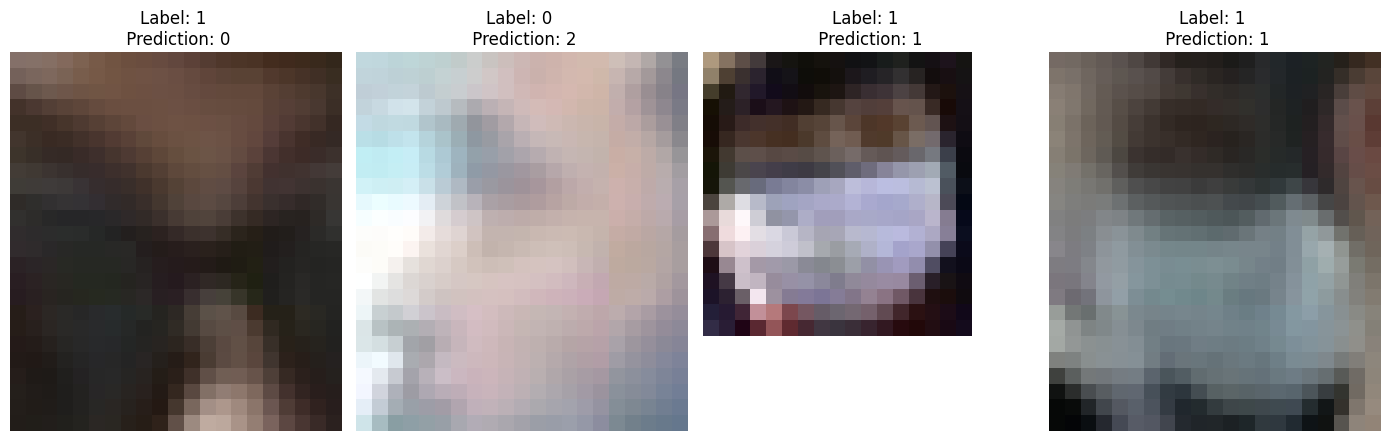

In [ ]:
    # Function to display model predictions and ground-truth labels for mask detection on random images from the test set.
    
    # Args:
    # path_to_testset (str): Path to the test set of the provided dataset.
    # model_type (str): String used to select a given model.
    
    #  where model_type can be one of
    #    - MLP
    #    - gridsearch_svm
    #    - CNN_transfer
    #    - CNN_BASIC



path_to_testset ="test"
model_type = 'MLP'
model = MaskDetection(path_to_testset, model_type)


# Test MaskDetectionVideo

In [ ]:
def pre_process_video(img, face, data_means, data_stds):
  
  input_ind = img[int(face[1]):int(face[3]), int(face[0]):int(face[2]), :]
  input_resized = np.resize(input_ind, (32, 32, 3))
  normalized_data = (input_resized - data_means) / data_stds

  return normalized_data

In [ ]:

def MaskDetectionVideo(video_path):
  
  # Open the video file and retrieve information about the frames
  cap = cv2.VideoCapture(video_path)
  frameCount = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
  frameWidth = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  frameHeight = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  
  # Create an empty numpy array to store the video frames
  video = np.empty((frameCount, frameHeight, frameWidth, 3), np.dtype('uint8'))

  fc = 0
  ret = True

  # Read frames from the video file and store them in the numpy array
  while fc < frameCount and ret:
      ret, video[fc] = cap.read()
      video[fc] = cv2.cvtColor(video[fc], cv2.COLOR_BGR2RGB)
      fc += 1

  cap.release()

  print(video.shape)

  n = 6
  fig, axes  = plt.subplots(nrows=1, ncols=n, figsize=(10, 5))
  inputs = np.empty((0, 32, 32, 3), dtype=np.float32)

  # Loop through a range of values
  for i in range(n):
    rand_num = random.randint(0, video.shape[0])
    img = video[rand_num, ...]

    # Detect faces in the image using MTCNN
    mtcnn = MTCNN(keep_all=True) 
    faces_MTCNN, _ = mtcnn.detect(img, landmarks=False) 
    if faces_MTCNN is not None:      
      for face in faces_MTCNN:
        # Pre-process the video frame for input to the model
        input_ind = pre_process_video(img, face, data_means, data_stds)

    # Prepare input tensor for the model
    inputs = np.expand_dims(input_ind, axis=0)
    inputs_tensor_ = torch.tensor(inputs.astype(np.float32))
    inputs_tensor = torch.permute(inputs_tensor_, [0, 3, 1, 2])
    inputs_tensor = inputs_tensor.contiguous()
    
    # Pass the input tensor to the model and get the predicted class
    outputs = model_CNN_BASIC(inputs_tensor)
    _, predicted = torch.max(outputs, 1)
    first_predicted = classes[predicted]

    # Display the image with face detection and predicted class label
    axes[i].imshow(img), axes[i].set_axis_off(), axes[i].set_title('Face detection using MTCNN')
    axes[i].add_patch(patches.Rectangle(xy=(face[0], face[1]), width=face[2]-face[0], height=face[3]-face[1],
                            fill=False, color='b', linewidth=2, label='test'))
    axes[i].set_title(f'Prediction: {first_predicted}')


### Call MaskDetectionVideo Function

(1309, 848, 480, 3)


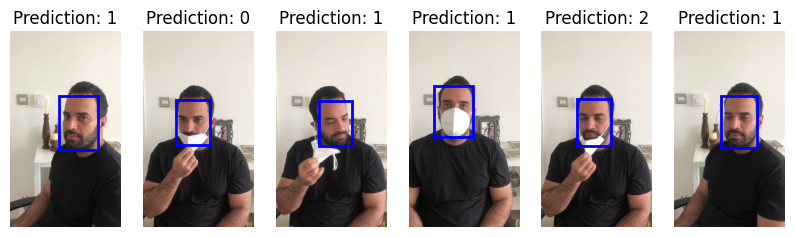

In [ ]:
# Syntax for the next function is the following:
#
# MaskDetectionVideo(video_path)
# Give the path of the video as argument to the function 

video_path = os.path.join(GOOGLE_DRIVE_PATH,'Video','video.mp4')
MaskDetectionVideo(video_path)
